In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures

import time
import duckdb 
conn = duckdb.connect("/global/scratch/users/empchase/A10_sequencing/v2/analysis.db") # create an in-memory database


In [2]:
pwd

'/global/scratch/users/empchase/LC_E1_step2/LC_E1_step2_testlibs_spikein'

In [3]:
# read in spike in files
path = '/global/scratch/users/empchase/LC_E1_step2/LC_E1_step2_testlibs_spikein/'
r1f = path + 'results/Staller_RPTR_E1_v1_MVS_0065_I1_CTATGGCGGA_CGGTAGAATT_S2.fastq.gz.assembled.fastq'
r2f = path + 'results/Staller_RPTR_E1_v2_MVS_0067_I1_GTCTTGTGCC_TCATGTAGGA_S4.fastq.gz.assembled.fastq'
a1f = path + 'results/Staller_AD_E1_MVS_0069_I1_AGCGAGCCAT_ACCGTAGATA_S6.fastq.gz.assembled.fastq'

#set consensus sequences

adp = 'CGGGCCC'#7 bp ; beforeAD barcode in read1
adf = 'GGCGCGC' #7bp ; after AD barcode in read1
tp = "TAGTCA" #tile
tf = "GCTAGC"

rpp = 'AGCGGCC' #7bp ; before rptr barcode in read1
rpf = 'CTCGAGT' #7 bp ; after rptr barcode in read1


In [4]:
#get list of designed tiles
a10design = '/global/scratch/users/empchase/A10_sequencing/v2/a10_designfile.csv'
a10dt = []

with open(a10design, 'r') as f:
    for line in f:
        if "ArrayDNA" in line:
            pass
        else:
            a10dt.append(line.strip())
# print(a10dt[:5])
print(len(a10dt))#20783

#create a dictionary of values
dtiles = {}
for i in a10dt:
    dtiles[i] = 1
    
# print(d)

20783


In [5]:
def complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'N':'N', 'X':'X'} 
    bases = list(seq) 
    bases = [complement[base] for base in bases] 
    return ''.join(bases)
def reverse_complement(s):
        return complement(s[::-1])
    
def getmid(seq, pre, post, bclen):
    # seq = the sequence to parse
    # pre = substring that precedes piece of interest
    # post = substring that follows piece of interest
    # returns piece of interest

    re_key = pre + "(.*)"+ post 
    poi_search = re.search(re_key, seq)
    if poi_search is None:
        #the barcode will be called X
        poi = "X"
        
        #then we search for which restriction site had the error
        #regex for the bc we want to ignore
        w = "(.{"+str(bclen)+"})" 
        pre_re = pre + w + "(.{7})"
        pre_search = re.search(pre_re, seq)
        post_re = "(\w{7})" + w + post
        post_search = re.search(post_re, seq)
        
        if pre_search is None and post_search is None:
            a = 'X'
            z = 'X'
        elif pre_search is None:
            poi = post_search.group(2)
            a = post_search.group(1)
            z = post
        elif post_search is None:
            poi = pre_search.group(1)
            z = pre_search.group(2)
            a = pre
        else:
            a = "Z"
            z = 'Z'            
    else:
        poi = poi_search.group(1)
        a = pre
        z = post
    
    return poi, a, z

In [21]:
# function that just looks for RPTR bc
def rbc_finder(readfile, bc_pre=rpp, bc_post=rpf, bc_len=14):
    #readfile = fastq file -- RPTR files are read1
    #default values for the pre/post regions defined in above cell
    
    # make lists of reads
    seqlist = []
    with open(readfile, 'r') as fin:
        for line in fin:
            if line.startswith('@'):
                #look at next line to get read sequence, add to list
                seq = next(fin)
                seq = seq.strip()
                seqlist.append(seq)

    
    #make lists of BCs from list of reads
    bc_list = []
    bc_lens = []       
    for read in seqlist:
        bc, prex, postx = getmid(read, bc_pre, bc_post, bc_len)
        bc = reverse_complement(bc) #return reverse complement
        bc_list.append(bc)
        bcl = len(bc)
        bc_lens.append(bcl)
        

    #make the dict/df
    BC_dict = {"BCs":bc_list, "Length":bc_lens} 
    BC_df = pd.DataFrame.from_dict(BC_dict)
    
    #label df with library name
    libname = '_'.join(readfile.split('/')[-1].split('_')[0:6])
    BC_df['Library'] = libname
    
    return BC_df




In [22]:
rptr1_bcs = rbc_finder(r1f)
rptr1_bcs.head()

,BCs,Length,Library
0,TGCTTATGCGCATC,14,Staller_RPTR_E1_v1_MVS_0065
1,TCTCCTCCCCTGCC,14,Staller_RPTR_E1_v1_MVS_0065
2,TGAGCGATATACGG,14,Staller_RPTR_E1_v1_MVS_0065
3,TATAATCTATGTAA,14,Staller_RPTR_E1_v1_MVS_0065
4,TTATCTGATGAAAG,14,Staller_RPTR_E1_v1_MVS_0065


In [58]:
# function that queries TBB table with a RPTRbc, returns the corresponding Tile, and inserts that TBB result into an empty list
def RPTR_SQLsearch1(query, map_='A10_1_2_MAP_20240320'):
    try:
        myquery = conn.sql(f"SELECT AD FROM {map_} WHERE RPTR_BC='{query}'").to_df()
        ptbb = myquery.loc[0,'AD'] #ptbb as in putative tbb
    except KeyError:
        ptbb = 0
    return ptbb

In [23]:
# function that queries TBB table with a RPTRbc, returns the corresponding Tile, and inserts that TBB result into an empty list
def RPTR_SQLsearch2(query, map_='A10_2_MAP_20240320'):
    try:
        myquery = conn.sql(f"SELECT AD FROM {map_} WHERE RPTR_BC='{query}'").to_df()
        ptbb = myquery.loc[0,'AD'] #ptbb as in putative tbb
    except KeyError:
        ptbb = 0
    return ptbb

In [25]:
RPTR_SQLsearch2('AGAAGAACTGAGGA')

'AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTTGTTCTACTTCTAAACCACCAGGTAATTTGTCTAGAACTCATGCTTATTCTTTGCCAACTACTCCACCAGCTACT'

In [26]:
testlist = ['AGAAGAACTGAGGA','GTTCTGTTCAATTA','AATTCTAAATAAGC', 'TTTGAGGGCCATTG', 'TTTAACGCATGAGT', 'TGCTCTTCCGATCT', 'bleljkrlkj', 'TGTGGGCATGTTAG' ]

testmatchlist=[]
start = time.perf_counter()
for x in testlist:
    y = RPTR_SQLsearch2(x)
    testmatchlist.append(y)
    finish = time.perf_counter()
    print(f'finished in {round(finish-start, 2)} seconds')
    
finish = time.perf_counter()
print(f'actually finished in {round(finish-start, 2)} seconds') #0.3
    
print(testmatchlist)

finished in 0.02 seconds
finished in 0.03 seconds
finished in 0.04 seconds
finished in 0.05 seconds
finished in 0.06 seconds
finished in 0.07 seconds
finished in 0.07 seconds
finished in 0.14 seconds
actually finished in 0.14 seconds
['AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTTGTTCTACTTCTAAACCACCAGGTAATTTGTCTAGAACTCATGCTTATTCTTTGCCAACTACTCCACCAGCTACT', 0, 0, 0, 0, 0, 0, 'GGTAATTATTTGTTCTCTGCTGCTGCTCATGTTCATAGATCTTCTAGATTGTTTATGACTGTTGATGCTAGATCTTCTGATCAAATGAAGATTGTTGATCCAGATATTTGGGGTGAAGAT']


In [27]:
testlist = ['AGAAGAACTGAGGA','GTTCTGTTCAATTA','AATTCTAAATAAGC', 'TTTGAGGGCCATTG', 'TTTAACGCATGAGT', 'TGCTCTTCCGATCT', 'bleljkrlkj', 'TGTGGGCATGTTAG' ]

testmatchlist = []

start = time.perf_counter()
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = executor.map(RPTR_SQLsearch2, testlist)
    for r in results:
        testmatchlist.append(r)
        finish = time.perf_counter()
        print(f'finished in {round(finish-start, 2)} seconds')

finish = time.perf_counter()
print(f'actually finished in {round(finish-start, 2)} seconds') #1.2
    
print(testmatchlist)

finished in 0.58 seconds
finished in 0.58 seconds
finished in 0.58 seconds
finished in 0.58 seconds
finished in 0.58 seconds
finished in 0.58 seconds
finished in 0.58 seconds
finished in 0.59 seconds
actually finished in 0.62 seconds
['AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTTGTTCTACTTCTAAACCACCAGGTAATTTGTCTAGAACTCATGCTTATTCTTTGCCAACTACTCCACCAGCTACT', 0, 0, 0, 0, 0, 0, 'GGTAATTATTTGTTCTCTGCTGCTGCTCATGTTCATAGATCTTCTAGATTGTTTATGACTGTTGATGCTAGATCTTCTGATCAAATGAAGATTGTTGATCCAGATATTTGGGGTGAAGAT']


In [15]:
conn.sql('SELECT * FROM A10_2_MAP_20240320 LIMIT 10')

┌───────────────────────────────────────────────────────────────────────────────────────┬─────────────┬────────────────┐
│                                          AD                                           │    AD_BC    │    RPTR_BC     │
│                                        varchar                                        │   varchar   │    varchar     │
├───────────────────────────────────────────────────────────────────────────────────────┼─────────────┼────────────────┤
│ AGATTGGAAGCTACTTATGAGAATATTAGAATTAATCAATCTTCTTGTTCTACTTCTAAACCACCAGGTAATTTGTCTAGAAC…  │ TTCGCTTAATG │ AGAAGAACTGAGGA │
│ ATGTCTGCTCCAAATTCTACTGCTTTGACTGCTTTGACTTCTCCATCTATTTATAATGAATCTCCAGACTTTAATGATGGTTA…  │ CCAGGTGATCA │ AGACTATAGAAGTG │
│ TTGCCAGATTTGTTTGACTTCTCTACTGATCAATTTGGTGCTGACTTTGATTTGTCTATGTTGTCTCCACAACAAATTCCAAC…  │ TATGAATGTTA │ TAATCGGATACGTA │
│ CCATCTTCTACTACTGCTTTGCAACAACAAAGACCAACTAGACCACAAGTTCCATTGTTCTCTCAATCTACTGGTAATGTTCC…  │ GGTCGAAGTTC │ AATTGACCCGTCAG │
│ GGTTTGGATAAGATTGAAGTTCCAGAATTG

In [28]:
def SQLanalyze_tiles_rptrbcs (df, bc_len=14):
    # df = barcode containing df, parsed from fastq
    # bc_len = int, expected barcode length
    # tbb_dictkey = str, either 'ADbc' or 'RPTRbc'
    
    print(df.loc[0,'Library'])

    tr = df.shape[0] #total reads
    print(f'Total Reads {tr}')
    
    cls = df[(df['Length']== bc_len)] #cl = correct length
    print('Reads w BC and Tile of correct length')
    clcount = cls.shape[0]
    print(clcount)
    
    print('% Reads w correct length BCs')
    clpct = cls.shape[0]/df.shape[0]
    print (clpct)
    
    #df of BC coverage
    cl_covdf = cls['BCs'].value_counts().to_frame().reset_index() 
    print('# Unique RPTR BCs')
    uniqbccount = cl_covdf.shape[0]
    print(uniqbccount)
    print('SUM Unique BCs')
    print(cl_covdf.sum(numeric_only=True)['BCs'])

    #copy down unique BCs into a list
    bcs = cl_covdf['index'].tolist()
    


    matchlist = [] #list of TBBs that match the BCs
    start = time.perf_counter()
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(RPTR_SQLsearch2, bcs)
        for r in results:
            matchlist.append(r)

    finish = time.perf_counter()
    print(f'finished in {round(finish-start, 2)} seconds')

            
    cl_covdf['PutativeTBB'] = matchlist
    
    matchesonly = cl_covdf.replace(0, np.nan)
    matchesonly = matchesonly.dropna()
    totmatches = matchesonly.sum(numeric_only=True)['BCs']
    print('# BC matches to A10 deep seq map (Current union)')
    mapmatches = matchesonly.shape[0]
    print(mapmatches)
    
    print('TOT BC matches to A10 deep seq map')
    print(totmatches)
    
#     print('% unique BCs matched')
#     print(totmatches/cl_covdf.shape[0])
    
    
    print()
    
    #label the df with library name
    
    libname = df.loc[0,'Library']
    cl_covdf['Library'] = libname
    
    statslist = [libname, tr, clcount, clpct, uniqbccount, mapmatches, totmatches]
    
    
    return matchesonly, statslist
    

In [29]:
rptr1_df, r1stats = SQLanalyze_tiles_rptrbcs(rptr1_bcs)

Staller_RPTR_E1_v1_MVS_0065
Total Reads 261208
Reads w BC and Tile of correct length
257723
% Reads w correct length BCs
0.9866581421702245
# Unique RPTR BCs
25320
SUM Unique BCs
257723
finished in 69.77 seconds
# BC matches to A10 deep seq map (Current union)
19561
TOT BC matches to A10 deep seq map
165771



In [30]:
rptr1_df

,index,BCs,PutativeTBB
1,TCGAACACGGCTTC,228,CCATCTGACTTTCCATTTCCAGAAACTTTGACTTCTTCTACTGCTT...
2,GGAGGGGTCAGAAG,188,TCTTCTTCATTTGGTTTGTCTGGTAATTCTTCTCAACATAGATTGT...
3,GTCACCAACGTTTA,185,GACCCAGTTGCTTTGAAGAGAGCTAGAAATACTGAAGCTGCTAGAA...
4,CCCCAGACTCGTTG,169,AGACCAGCTAGACCACCAGTTCCATTGTTCTCTCAATCTACTGGTT...
5,TGGAAGATGATCCA,168,ACTAGAAGACAAAGATCTTCTCCATTGGCTCCAATTGTTGTTAAAG...
...,...,...,...
25314,TGACCGGATTAAAC,1,CCAAAAACTTCTTCTTCTTTGCCAACTCCAGTCTTGGATAATGAAA...
25315,TGACATTCTTGACT,1,AATCAACAAGCTCCAGATGCTCAACCACATCCATCTTCTCCAGCTC...
25316,ACCCTTTAACGATT,1,CCAAGATTTCAAGCTAGGAAATCTCACTTTAGAAATACTTGGGCTA...
25318,CCAAGGTTAGTTCT,1,TCTCCAGAATTTGATTCTTATGAGTTCTCTCCAAACTTTGGTGATT...


<Axes: xlabel='BCs', ylabel='Count'>

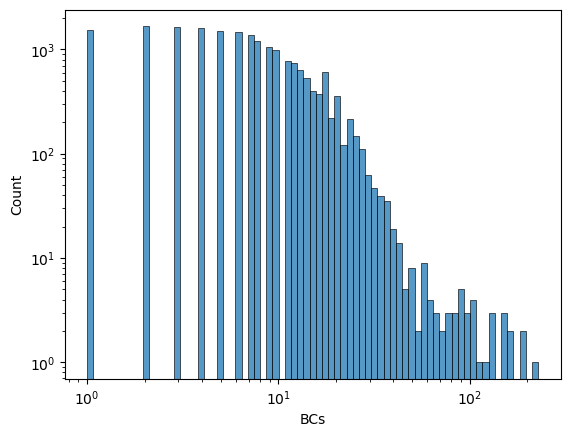

In [43]:
sns.histplot(data=rptr1_df, x='BCs', log_scale=(True, True))

In [45]:
rptr2_bcs = rbc_finder(r2f)
rptr2_bcs.head()

,BCs,Length,Library
0,ACTTCTAAATAAGC,14,Staller_RPTR_E1_v2_MVS_0067
1,ATAAATAGAGGTTC,14,Staller_RPTR_E1_v2_MVS_0067
2,TGAATAACATTAGT,14,Staller_RPTR_E1_v2_MVS_0067
3,TTGCTAAATTTTGT,14,Staller_RPTR_E1_v2_MVS_0067
4,AGTCCGATGTATAG,14,Staller_RPTR_E1_v2_MVS_0067


In [46]:
rptr2_df, r2stats = SQLanalyze_tiles_rptrbcs(rptr2_bcs)

Staller_RPTR_E1_v2_MVS_0067
Total Reads 358303
Reads w BC and Tile of correct length
353155
% Reads w correct length BCs
0.9856322721272219
# Unique RPTR BCs
26055
SUM Unique BCs
353155
finished in 70.71 seconds
# BC matches to A10 deep seq map (Current union)
20057
TOT BC matches to A10 deep seq map
228747



<Axes: xlabel='BCs', ylabel='Count'>

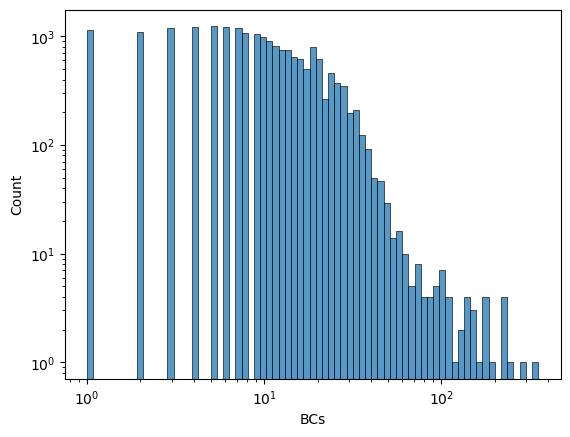

In [47]:
sns.histplot(data=rptr2_df, x='BCs', log_scale=(True, True))

In [48]:
int_df_rptr = rptr1_df.merge(rptr2_df, how='inner', on='index')
int_df_rptr

,index,BCs_x,PutativeTBB_x,BCs_y,PutativeTBB_y
0,TCGAACACGGCTTC,228,CCATCTGACTTTCCATTTCCAGAAACTTTGACTTCTTCTACTGCTT...,351,CCATCTGACTTTCCATTTCCAGAAACTTTGACTTCTTCTACTGCTT...
1,GGAGGGGTCAGAAG,188,TCTTCTTCATTTGGTTTGTCTGGTAATTCTTCTCAACATAGATTGT...,291,TCTTCTTCATTTGGTTTGTCTGGTAATTCTTCTCAACATAGATTGT...
2,GTCACCAACGTTTA,185,GACCCAGTTGCTTTGAAGAGAGCTAGAAATACTGAAGCTGCTAGAA...,243,GACCCAGTTGCTTTGAAGAGAGCTAGAAATACTGAAGCTGCTAGAA...
3,CCCCAGACTCGTTG,169,AGACCAGCTAGACCACCAGTTCCATTGTTCTCTCAATCTACTGGTT...,223,AGACCAGCTAGACCACCAGTTCCATTGTTCTCTCAATCTACTGGTT...
4,TGGAAGATGATCCA,168,ACTAGAAGACAAAGATCTTCTCCATTGGCTCCAATTGTTGTTAAAG...,232,ACTAGAAGACAAAGATCTTCTCCATTGGCTCCAATTGTTGTTAAAG...
...,...,...,...,...,...
19074,TGATAAATTATAAG,1,TCTACTGCTCCAGATGCTCCAGCTCCTAAACCATCTCCAGCTCAAG...,5,TCTACTGCTCCAGATGCTCCAGCTCCTAAACCATCTCCAGCTCAAG...
19075,TGACCGGATTAAAC,1,CCAAAAACTTCTTCTTCTTTGCCAACTCCAGTCTTGGATAATGAAA...,3,CCAAAAACTTCTTCTTCTTTGCCAACTCCAGTCTTGGATAATGAAA...
19076,TGACATTCTTGACT,1,AATCAACAAGCTCCAGATGCTCAACCACATCCATCTTCTCCAGCTC...,9,AATCAACAAGCTCCAGATGCTCAACCACATCCATCTTCTCCAGCTC...
19077,ACCCTTTAACGATT,1,CCAAGATTTCAAGCTAGGAAATCTCACTTTAGAAATACTTGGGCTA...,4,CCAAGATTTCAAGCTAGGAAATCTCACTTTAGAAATACTTGGGCTA...


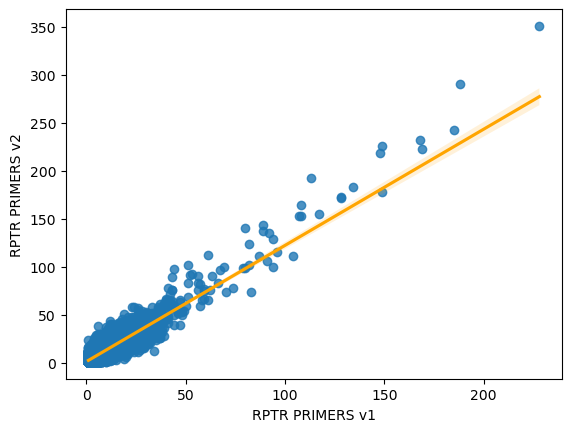

In [57]:
ax = sns.regplot(x='BCs_x', y= 'BCs_y', data=int_df_rptr, line_kws=dict(color="orange"),)
ax.set(xlabel = 'RPTR PRIMERS v1', ylabel = 'RPTR PRIMERS v2')
# ax.set_xscale('log')
# ax.set_yscale('log')

# plt.savefig('figures/20240321/A10_tbb_dotcorr_FIL.jpg')

plt.show()

In [55]:
all_rptr = pd.concat([rptr1_df.assign(dataset='set1'), rptr2_df.assign(dataset='set2')])
all_rptr.head()

,index,BCs,PutativeTBB,dataset
1,TCGAACACGGCTTC,228,CCATCTGACTTTCCATTTCCAGAAACTTTGACTTCTTCTACTGCTT...,set1
2,GGAGGGGTCAGAAG,188,TCTTCTTCATTTGGTTTGTCTGGTAATTCTTCTCAACATAGATTGT...,set1
3,GTCACCAACGTTTA,185,GACCCAGTTGCTTTGAAGAGAGCTAGAAATACTGAAGCTGCTAGAA...,set1
4,CCCCAGACTCGTTG,169,AGACCAGCTAGACCACCAGTTCCATTGTTCTCTCAATCTACTGGTT...,set1
5,TGGAAGATGATCCA,168,ACTAGAAGACAAAGATCTTCTCCATTGGCTCCAATTGTTGTTAAAG...,set1


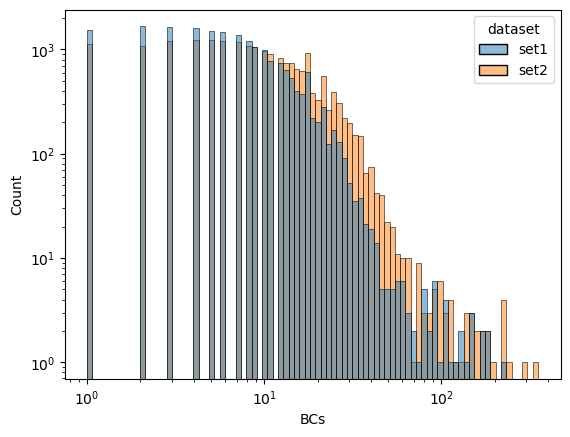

In [56]:
sns.histplot(x='BCs', data=all_rptr, log_scale=(True, True),
                hue='dataset')
# plt.savefig('A10_tbb_comp_FIL.jpg')

plt.show()

In [60]:
rptr2_df_m1, r2stats_m1 = SQLanalyze_tiles_rptrbcs(rptr2_bcs)

Staller_RPTR_E1_v2_MVS_0067
Total Reads 358303
Reads w BC and Tile of correct length
353155
% Reads w correct length BCs
0.9856322721272219
# Unique RPTR BCs
26055
SUM Unique BCs
353155
finished in 24.77 seconds
# BC matches to A10 deep seq map (Current union)
17066
TOT BC matches to A10 deep seq map
195169



In [61]:
twomethods_rptr = pd.concat([rptr2_df_m1.assign(dataset='set1'), rptr2_df.assign(dataset='set2')])
twomethods_rptr.head()

,index,BCs,PutativeTBB,dataset
1,TCGAACACGGCTTC,351,CCATCTGACTTTCCATTTCCAGAAACTTTGACTTCTTCTACTGCTT...,set1
2,GGAGGGGTCAGAAG,291,TCTTCTTCATTTGGTTTGTCTGGTAATTCTTCTCAACATAGATTGT...,set1
3,GTCACCAACGTTTA,243,GACCCAGTTGCTTTGAAGAGAGCTAGAAATACTGAAGCTGCTAGAA...,set1
4,TGGAAGATGATCCA,232,TTCTTTGACTTTACTGAAGGATTTGGTGAAGACTTTGCTGATCCAA...,set1
5,TTAAACCTTCGTCG,226,CAAGGTGAACCAATGTTAAATTCTTCTAATGATTGGTTCTCTTTGT...,set1


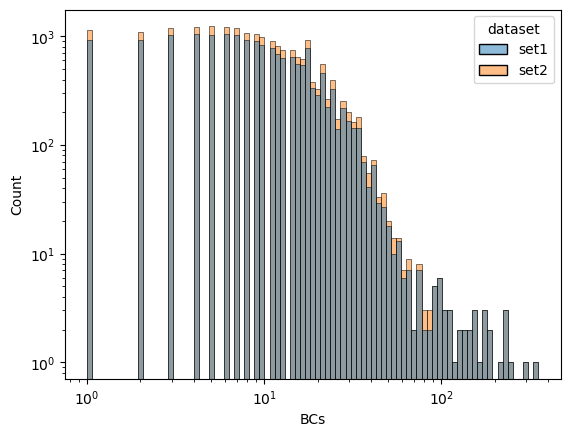

In [62]:
sns.histplot(x='BCs', data=twomethods_rptr, log_scale=(True, True),
                hue='dataset')
# plt.savefig('A10_tbb_comp_FIL.jpg')

plt.show()

In [7]:
# function that just looks for Tile/AD bc
def adbc_mapper(readfile, tile_pre = tp, tile_post = tf, 
                  adBC_pre = adp, adBC_post = adf):
    #readfile = fastq (ADBC fastqs are typically paired)
    # *_pre or *_post = the consensus sequences before or after each feature, defaults defined above

    # make lists of reads
    readlist = []    
    with open(readfile, 'r') as fin:
        for line in fin:
            if line.startswith('@'):
                #look at next line to get read sequence, add to list
                seq = next(fin)
                seq = seq.strip()
                readlist.append(seq)
                
    #make lists of tiles/BCs from list of reads
    tile_list = []
    tile_lengths= []
    
    des_query = [] # tells us if tile matches design or not
    
    adBC_list = []
    adBC_lengths = []
    
    tile_adbc = []
   
    
    for read in readlist:
        tile, tpre, tpost = getmid(read, tile_pre, tile_post, 120) #use consensus seq to find tile
        tile = reverse_complement(tile)
        tile_list.append(tile) #add tile to list
        tile_len = len(tile) #find length of tile
        tile_lengths.append(tile_len) #add length to list
            
        if tile in dtiles:
            des_query.append(1)
        else:
            des_query.append(0)
#         print(tile)
        
        adBC, prea, posta = getmid(read, adBC_pre, adBC_post, 11)
        adBC = reverse_complement(adBC)
        adBC_list.append(adBC)
        adBC_len = len(adBC)
        adBC_lengths.append(adBC_len)
        
        tile_adbc.append(tile+'-'+adBC)

            
    # make the df
    tileBC_dict = {"Tiles":tile_list, "T Len" : tile_lengths, "Designed": des_query, 
                  "AD BCs":adBC_list, "A Len": adBC_lengths, 'Tile-AD': tile_adbc}
    tileBC_df = pd.DataFrame.from_dict(tileBC_dict)
    
    libname = '_'.join(readfile.split('/')[-1].split('_')[0:6])
    tileBC_df['Library'] = libname
    
    return tileBC_df


In [8]:
ad_bcs = adbc_mapper(a1f)
ad_bcs.head()

,Tiles,T Len,Designed,AD BCs,A Len,Tile-AD,Library
0,TGGGGTTCATGCTGCTACTGCTGAACATCCAGCTATTAGAAGATTG...,121,0,TACACCCTTTG,11,TGGGGTTCATGCTGCTACTGCTGAACATCCAGCTATTAGAAGATTG...,Staller_AD_E1_MVS_0069_I1
1,GGTGATAGATTGTCTAGAGCTTTGGGTTGGAGACCATGTTTGAGAT...,120,1,GCAGCTTCGTC,11,GGTGATAGATTGTCTAGAGCTTTGGGTTGGAGACCATGTTTGAGAT...,Staller_AD_E1_MVS_0069_I1
2,TGTCCAATTTCTAATGAAATCTTGGGTTTGACTCCAGAATTGGTGG...,119,0,CTAGCTAGCCT,11,TGTCCAATTTCTAATGAAATCTTGGGTTTGACTCCAGAATTGGTGG...,Staller_AD_E1_MVS_0069_I1
3,ACTAATTTGCATGGTGTTAATGATATTGATCATACTCCAATGTTTG...,120,1,CCAGCACGTGC,11,ACTAATTTGCATGGTGTTAATGATATTGATCATACTCCAATGTTTG...,Staller_AD_E1_MVS_0069_I1
4,GATTTGAACTTTGGTCATCAATTGATTCATTTGGTTCTTCTTCTTT...,119,0,GATGTGGTGGT,11,GATTTGAACTTTGGTCATCAATTGATTCATTTGGTTCTTCTTCTTT...,Staller_AD_E1_MVS_0069_I1


In [73]:
ad_bcs[(ad_bcs['Designed']==1)]

,Tiles,T Len,Designed,AD BCs,A Len,Tile-AD,Library
1,GGTGATAGATTGTCTAGAGCTTTGGGTTGGAGACCATGTTTGAGAT...,120,1,GCAGCTTCGTC,11,GGTGATAGATTGTCTAGAGCTTTGGGTTGGAGACCATGTTTGAGAT...,Staller_AD_E1_MVS_0069_I1
3,ACTAATTTGCATGGTGTTAATGATATTGATCATACTCCAATGTTTG...,120,1,CCAGCACGTGC,11,ACTAATTTGCATGGTGTTAATGATATTGATCATACTCCAATGTTTG...,Staller_AD_E1_MVS_0069_I1
5,CCATTTATGTCTGCTCCAAATTCTACTGCTTTGACTGCTTTGACTT...,120,1,CGCTCCCACTT,11,CCATTTATGTCTGCTCCAAATTCTACTGCTTTGACTGCTTTGACTT...,Staller_AD_E1_MVS_0069_I1
7,ACTGGTGCTGTCTTCTTCTTGTTGGGTGCTGCTAAATTGGGTTCTT...,120,1,TGCGTGGGCGA,11,ACTGGTGCTGTCTTCTTCTTGTTGGGTGCTGCTAAATTGGGTTCTT...,Staller_AD_E1_MVS_0069_I1
8,TCTCAAGAACCATTGAACTTCTCTATTGCTTCTAGATCTTCTTCTT...,120,1,GATCCCCCTCC,11,TCTCAAGAACCATTGAACTTCTCTATTGCTTCTAGATCTTCTTCTT...,Staller_AD_E1_MVS_0069_I1
...,...,...,...,...,...,...,...
284019,TACTTTATGGCTATTCCAGCTGTCTTCTATGTTATTGTTGTTGGAT...,120,1,TGAAATTTGCT,11,TACTTTATGGCTATTCCAGCTGTCTTCTATGTTATTGTTGTTGGAT...,Staller_AD_E1_MVS_0069_I1
284020,TCTCATCAACAATATAGAAGACAACAACCAGTTTCTCCAGCTGTTC...,120,1,ACGCCTCCAGC,11,TCTCATCAACAATATAGAAGACAACAACCAGTTTCTCCAGCTGTTC...,Staller_AD_E1_MVS_0069_I1
284022,CATCAACAAACTTGGTTGCCAACTCCACCACCACCACAACCAACTG...,120,1,TATACACCATT,11,CATCAACAAACTTGGTTGCCAACTCCACCACCACCACAACCAACTG...,Staller_AD_E1_MVS_0069_I1
284024,AGGAAAGGTCCATTGCCATCTATTACTGTTGATCCAAATGATAAAG...,120,1,AGATCTGGACA,11,AGGAAAGGTCCATTGCCATCTATTACTGTTGATCCAAATGATAAAG...,Staller_AD_E1_MVS_0069_I1


In [9]:
# function that queries TBB table with a RPTRbc, returns the corresponding Tile, and inserts that TBB result into an empty list
def AD_SQLsearch1(query, map_='A10_1_2_MAP_20240320'):
    try:
        myquery = conn.sql(f"SELECT RPTR_BC FROM {map_} WHERE AD_BC='{query}'").to_df()
        ptbb = myquery.loc[0,'RPTR_BC'] #ptbb as in putative tbb
    except KeyError:
        ptbb = 0
    return ptbb

In [10]:
# function that queries TBB table with a RPTRbc, returns the corresponding Tile, and inserts that TBB result into an empty list
def AD_SQLsearch2(query, map_='A10_2_MAP_20240320'):
    try:
        myquery = conn.sql(f"SELECT RPTR_BC FROM {map_} WHERE AD_BC='{query}'").to_df()
        ptbb = myquery.loc[0,'RPTR_BC'] #ptbb as in putative tbb
    except KeyError:
        ptbb = 0
    return ptbb

In [11]:
conn.sql('SELECT AD_BC, RPTR_BC FROM A10_2_MAP_20240320 LIMIT 10')

┌─────────────┬────────────────┐
│    AD_BC    │    RPTR_BC     │
│   varchar   │    varchar     │
├─────────────┼────────────────┤
│ TTCGCTTAATG │ AGAAGAACTGAGGA │
│ CCAGGTGATCA │ AGACTATAGAAGTG │
│ TATGAATGTTA │ TAATCGGATACGTA │
│ GGTCGAAGTTC │ AATTGACCCGTCAG │
│ CGGCCCTTTCC │ ATGGCGCCCTCGAA │
│ GGCTGGAATGT │ CCAACTACCCGTGG │
│ TAATAGATTTT │ ATTATGCTGTGGGG │
│ AAGATTTCTTC │ CGGCTTGCCCGAGA │
│ CTAAGAGAAAG │ CGGGTACCTATGTG │
│ AACGCGACAAG │ ACCACAGCTTCTGC │
├─────────────┴────────────────┤
│ 10 rows            2 columns │
└──────────────────────────────┘

In [12]:
conn.sql("SELECT RPTR_BC FROM A10_2_MAP_20240320 WHERE AD_BC = 'TTCGCTTAATG'").df()

,RPTR_BC
0,AGAAGAACTGAGGA
1,AGAAGAGCTGAGGA
2,AGTAGAACTGAGGA
3,AAACGACAGGAAAA
4,AGAAGAACTGACGA


In [15]:
testlist = ['GCAGCTTCGTC','CCAGGTGATCA','TATGAATGTTA', 'TTTGAGGGCCATTG', 'TTTAACGCATGAGT', 'TGCTCTTCCGATCT', 'bleljkrlkj', 'TGTGGGCATGTTAG' ]

testmatchlist = []

start = time.perf_counter()
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = executor.map(AD_SQLsearch2, testlist)
    for r in results:
        testmatchlist.append(r)
        finish = time.perf_counter()
        print(f'finished in {round(finish-start, 2)} seconds')

finish = time.perf_counter()
print(f'actually finished in {round(finish-start, 2)} seconds') #1.2
    
print(testmatchlist)

finished in 0.51 seconds
finished in 0.51 seconds
finished in 0.51 seconds
finished in 0.51 seconds
finished in 0.51 seconds
finished in 0.51 seconds
finished in 0.51 seconds
finished in 0.51 seconds
actually finished in 0.53 seconds
['CAGAGCATAAACGG', 'AGACTATAGAAGTG', 'TAATCGGATACGTA', 0, 0, 0, 0, 0]


In [33]:
def SQLanalyze_tiles_adbcs (df, bc_len=11, tile_len=120):
    # df = barcode containing df, parsed from fastq
    # bc_len = int, expected barcode length
    # tbb_dictkey = str, either 'ADbc' or 'RPTRbc'
    
    print(df.loc[0,'Library'])

    tr = df.shape[0] #total reads
    print(f'Total Reads {tr}')
    cls = df[(df['A Len']== bc_len) & (df['T Len']==tile_len)] #cl = correct length
    print('Reads w BC and Tile of correct length')
    clcount = cls.shape[0]
    print(clcount)
    
    print('% Reads w correct length Tiles/BCs')
    clpct = cls.shape[0]/df.shape[0]
    print (clpct)
    
    #df of BC coverage
    cl_covdf = cls['AD BCs'].value_counts().to_frame().reset_index() 
    print('# Unique ADbcs')
    uniqbccount = cl_covdf.shape[0]
    print(uniqbccount)
    print('SUM Unique BCs')
    print(cl_covdf.sum(numeric_only=True)['AD BCs'])

    #copy down unique BCs into a list
    bcs = cl_covdf['index'].tolist()
    


    matchlist = [] #list of numbers that correspond to how many times a tile-ad was represented in the experiment

    
    start = time.perf_counter()
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(AD_SQLsearch1, bcs)
        for r in results:
            matchlist.append(r)

    finish = time.perf_counter()
    print(f'finished in {round(finish-start, 2)} seconds')
    
            

            
    cl_covdf['RPTRBC_Represented'] = matchlist
    
    matchesonly = cl_covdf.replace(0, np.nan)
    matchesonly = matchesonly.dropna()
    totmatches = matchesonly.sum(numeric_only=True)['AD BCs']
    print('# BC matches to A10 deep seq map')
    mapmatches = matchesonly.shape[0]
    print(mapmatches)
    
    print('TOT BC matches to A10 deep seq map')
    print(totmatches)
    
#     print('% unique BCs matched')
#     print(totmatches/cl_covdf.shape[0])
    
    
    print()
    
    #label the df with library name
    
    libname = df.loc[0,'Library']
    cl_covdf['Library'] = libname
    
    statslist = [libname, tr, clcount, clpct, uniqbccount, mapmatches, totmatches]
    
    
    return matchesonly, statslist
    

In [19]:
ad_df, adstats = SQLanalyze_tiles_adbcs(ad_bcs)

Staller_AD_E1_MVS_0069_I1
Total Reads 284027
Reads w BC and Tile of correct length
179663
% Reads w correct length Tiles/BCs
0.6325560598112151
# Unique ADbcs
21050
SUM Unique BCs
179663
finished in 31.25 seconds
# BC matches to A10 deep seq map
19374
TOT BC matches to A10 deep seq map
175611



In [20]:
ad_df

,index,AD BCs,RPTRBC_Represented
0,GACTTGTCTGG,258,TTGCTAAATTTTGT
1,TCCTAAGCTCG,249,CCCCAGACTCGTTG
2,TTTCCGGCCCT,232,CATGACTAGGCTTC
3,ACACTTTATGC,229,TTAGCTAGAATATT
4,CATAGTCCTTC,183,TCATATCTCTTTCC
...,...,...,...
21041,AGGGGATCGTA,1,CACTCGATAAAAGT
21043,AGCGGACCCCC,1,TCGATAGTACATAA
21045,ACTTAAACGAC,1,CTCCCTTTGCGCCC
21047,AGATACTTCAT,1,TCCCCATTTAAGCC


<Axes: xlabel='AD BCs', ylabel='Count'>

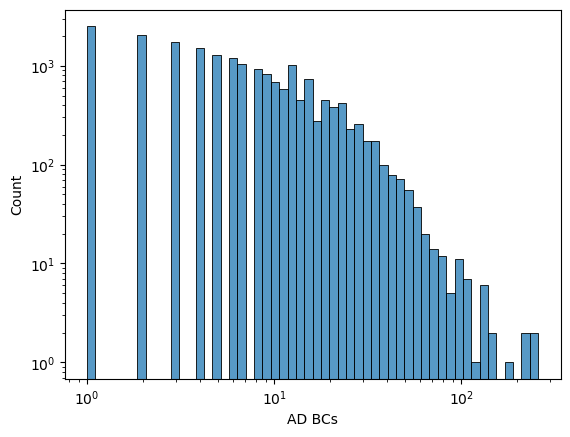

In [32]:
sns.histplot(data=ad_df, x='AD BCs', log_scale=(True, True))

In [34]:
ad_df2, adstats2 = SQLanalyze_tiles_adbcs(ad_bcs)

Staller_AD_E1_MVS_0069_I1
Total Reads 284027
Reads w BC and Tile of correct length
179663
% Reads w correct length Tiles/BCs
0.6325560598112151
# Unique ADbcs
21050
SUM Unique BCs
179663
finished in 11.87 seconds
# BC matches to A10 deep seq map
18757
TOT BC matches to A10 deep seq map
171429



In [35]:
ad_df2

,index,AD BCs,RPTRBC_Represented
0,GACTTGTCTGG,258,TTGCTAAATTTTGT
1,TCCTAAGCTCG,249,CCCCAGACTCGTTG
2,TTTCCGGCCCT,232,CATGACTAGGCTTC
3,ACACTTTATGC,229,TTAGCTAGAATATT
4,CATAGTCCTTC,183,TCATATCTCTTTCC
...,...,...,...
21041,AGGGGATCGTA,1,CACTCGATAAAAGT
21043,AGCGGACCCCC,1,TCGATAGTACATAA
21045,ACTTAAACGAC,1,CTCCCTTTGCGCCC
21047,AGATACTTCAT,1,TCCCCATTTAAGCC


In [36]:
twomethods_ad = pd.concat([ad_df2.assign(dataset='set1'), ad_df.assign(dataset='set2')])
twomethods_ad.head()

,index,AD BCs,RPTRBC_Represented,dataset
0,GACTTGTCTGG,258,TTGCTAAATTTTGT,set1
1,TCCTAAGCTCG,249,CCCCAGACTCGTTG,set1
2,TTTCCGGCCCT,232,CATGACTAGGCTTC,set1
3,ACACTTTATGC,229,TTAGCTAGAATATT,set1
4,CATAGTCCTTC,183,TCATATCTCTTTCC,set1


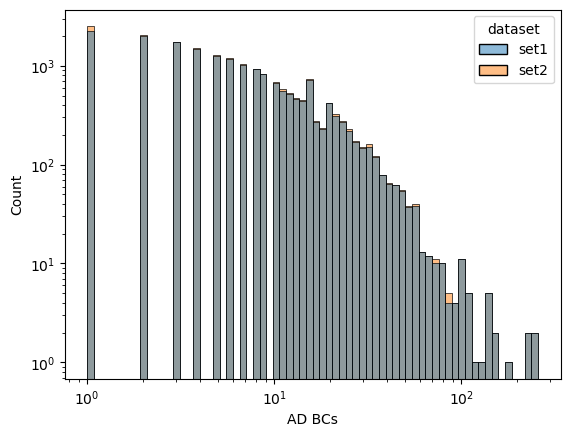

In [37]:
sns.histplot(x='AD BCs', data=twomethods_ad, log_scale=(True, True),
                hue='dataset')
# plt.savefig('A10_tbb_comp_FIL.jpg')

plt.show()

In [46]:
ad_df = ad_df.rename(columns={'RPTRBC_Represented':'RPTR_BC', 'AD BCs':'ADBC_Counts', 'index': 'AD_BC'})
rptr1_df = rptr1_df.rename(columns={'index':'RPTR_BC', 'BCs':'RPTRBC_Counts'})

In [43]:
rptr1_df

,RPTR_BC,RPTRBC_Counts,PutativeTBB
1,TCGAACACGGCTTC,228,CCATCTGACTTTCCATTTCCAGAAACTTTGACTTCTTCTACTGCTT...
2,GGAGGGGTCAGAAG,188,TCTTCTTCATTTGGTTTGTCTGGTAATTCTTCTCAACATAGATTGT...
3,GTCACCAACGTTTA,185,GACCCAGTTGCTTTGAAGAGAGCTAGAAATACTGAAGCTGCTAGAA...
4,CCCCAGACTCGTTG,169,AGACCAGCTAGACCACCAGTTCCATTGTTCTCTCAATCTACTGGTT...
5,TGGAAGATGATCCA,168,ACTAGAAGACAAAGATCTTCTCCATTGGCTCCAATTGTTGTTAAAG...
...,...,...,...
25314,TGACCGGATTAAAC,1,CCAAAAACTTCTTCTTCTTTGCCAACTCCAGTCTTGGATAATGAAA...
25315,TGACATTCTTGACT,1,AATCAACAAGCTCCAGATGCTCAACCACATCCATCTTCTCCAGCTC...
25316,ACCCTTTAACGATT,1,CCAAGATTTCAAGCTAGGAAATCTCACTTTAGAAATACTTGGGCTA...
25318,CCAAGGTTAGTTCT,1,TCTCCAGAATTTGATTCTTATGAGTTCTCTCCAAACTTTGGTGATT...


In [47]:
ad_df

,AD_BC,ADBC_Counts,RPTR_BC
0,GACTTGTCTGG,258,TTGCTAAATTTTGT
1,TCCTAAGCTCG,249,CCCCAGACTCGTTG
2,TTTCCGGCCCT,232,CATGACTAGGCTTC
3,ACACTTTATGC,229,TTAGCTAGAATATT
4,CATAGTCCTTC,183,TCATATCTCTTTCC
...,...,...,...
21041,AGGGGATCGTA,1,CACTCGATAAAAGT
21043,AGCGGACCCCC,1,TCGATAGTACATAA
21045,ACTTAAACGAC,1,CTCCCTTTGCGCCC
21047,AGATACTTCAT,1,TCCCCATTTAAGCC


In [48]:
corr_df = rptr1_df.merge(ad_df, how='inner', on='RPTR_BC', suffixes=('_r', '_a'))
corr_df

,RPTR_BC,RPTRBC_Counts,PutativeTBB,AD_BC,ADBC_Counts
0,TCGAACACGGCTTC,228,CCATCTGACTTTCCATTTCCAGAAACTTTGACTTCTTCTACTGCTT...,TTATTCGAATT,137
1,GGAGGGGTCAGAAG,188,TCTTCTTCATTTGGTTTGTCTGGTAATTCTTCTCAACATAGATTGT...,CGCGGCTACAA,46
2,CCCCAGACTCGTTG,169,AGACCAGCTAGACCACCAGTTCCATTGTTCTCTCAATCTACTGGTT...,TCCTAAGCTCG,249
3,TGGAAGATGATCCA,168,ACTAGAAGACAAAGATCTTCTCCATTGGCTCCAATTGTTGTTAAAG...,AGATTGGCAAC,2
4,TTAAACCTTCGTCG,149,CAAGGTGAACCAATGTTAAATTCTTCTAATGATTGGTTCTCTTTGT...,GTCCGTAGGGA,102
...,...,...,...,...,...
14003,GAAGTGAAACTAAT,1,CCAAATTCTACTGCATTTACTAATTTGACTTCTCCAGATTCTCAAT...,TGAGTGATTTG,6
14004,GTATTGTGACAATA,1,GTTTCTCCACAAGAATTGTTGTTGCATGAACCATATTTGTCTGCTC...,GTACTCTATCC,2
14005,TGACATTCTTGACT,1,AATCAACAAGCTCCAGATGCTCAACCACATCCATCTTCTCCAGCTC...,GGAATCTAGGA,1
14006,ACCCTTTAACGATT,1,CCAAGATTTCAAGCTAGGAAATCTCACTTTAGAAATACTTGGGCTA...,GCTGTCACTAT,2


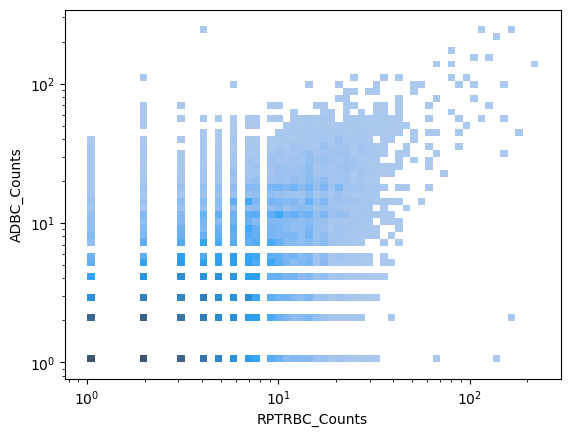

In [49]:
ax = sns.histplot(x='RPTRBC_Counts', y= 'ADBC_Counts', data=corr_df, log_scale=(True, True))
# ax.set(xlabel = 'RPTR BC', ylabel = 'AD BC')
# ax.set_xscale('log')
# ax.set_yscale('log')

# plt.savefig('figures/20240321/A10_tbb_dotcorr_FIL.jpg')

plt.show()

In [50]:
conn.close()